<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_1024CNN_layer_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 層の可視化デモ

In [17]:
%config InlineBackend.figure_format = 'retina'
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1
    !git clone https://github.com/ShinAsakawa/bit.git
    import bit

isColab = bit.isColab
HOME = bit.HOME

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib    
    import japanize_matplotlib


In [ ]:
import torch
import torchvision
from torchvision import models, transforms
from termcolor import colored

# 各モデルを定義し，訓練済み結合係数をダウンロード
DNNs = {}
DNNs['resnet18'] = models.resnet18(weights='DEFAULT', progress=True)
# DNNs['alexnet'] = models.alexnet(weights='DEFAULT', progress=True)
# DNNs['vgg16'] = models.vgg16(weights='DEFAULT', progress=True)
# DNNs['squeezenet']= models.squeezenet1_0(weights='DEFAULT', progress=True)
# DNNs['densenet'] = models.densenet161(weights='DEFAULT', progress=True)
# DNNs['inception'] = models.inception_v3(weights='DEFAULT', progress=True)
# DNNs['googlenet'] = models.googlenet(weights='DEFAULT', progress=True)
# DNNs['shufflenet'] = models.shufflenet_v2_x1_0(weights='DEFAULT', progress=True)
# DNNs['mobilenet'] = models.mobilenet_v2(weights='DEFAULT', progress=True)
# DNNs['resnext50_32x4d'] = models.resnext50_32x4d(weights='DEFAULT', progress=True)
# DNNs['wide_resnet50_2'] = models.wide_resnet50_2(weights='DEFAULT', progress=True)
# DNNs['mnasnet'] = models.mnasnet1_0(weights='DEFAULT', progress=True)

# 上の中から試したいモデルを選んでください。最後のモデルが有効になります。
net = DNNs['resnet18'] 
#net = DNNs['squeezenet']
#net = DNNs['googlenet']
#net = DNNs['shufflenet']
#net = DNNs['mobilenet']
#net = DNNs['vgg16']
#net = DNNs['alexnet']

transform = transforms.Compose([
    transforms.ToTensor()])

# # RGB 各チャンネルの平均と分散の定義。CNN 唯一の前処理
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

resnet_pt = net
resnet_pt.eval()

In [ ]:
import torchsummary
torchsummary.summary(resnet_pt,input_size=(3,224,224))


In [5]:
try:
    import torchviz
except ImportError:
    !pip install torchviz
    import torchviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=ecac8cf32412c5fd8ad1705d10ba5dd4ed99f4b57b25b279caafc737ac381464
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
#resnet_pt
import torchsummary
torchsummary.summary(resnet_pt,input_size=(3,224,224))


In [ ]:

from torchviz import make_dot

x = torch.rand([1,3,224,224])
y = resnet_pt.forward(x)
make_dot(y.mean(), params=dict(resnet_pt.named_parameters()))    

In [ ]:
#for name, module in resnet_pt.named_children():
#    print(name) # , module)
#print(resnet_pt.layer4)    
for i, layer in enumerate(resnet_pt.named_modules()):
    print(i, layer[0], type(layer[1]))

In [10]:
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)

    def clear(self):
        self.outputs = []

saved_output = SaveOutput()
hook_handles = []
hooked_modules = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
for layer in resnet_pt.named_modules():
    if layer[0] in hooked_modules:
        print(f'{layer[0]} hooked {type(layer[1])}')
        handle = layer[1].register_forward_hook(saved_output)
        hook_handles.append(handle)
    
#resnet_pt.eval()    
hook_handles

conv1 hooked <class 'torch.nn.modules.conv.Conv2d'>
layer1 hooked <class 'torch.nn.modules.container.Sequential'>
layer2 hooked <class 'torch.nn.modules.container.Sequential'>
layer3 hooked <class 'torch.nn.modules.container.Sequential'>
layer4 hooked <class 'torch.nn.modules.container.Sequential'>


In [ ]:
!wget -O cat.jpg https://www.cats.org.uk/media/6189/manja-vitolic-gkxkby-c-dk-unsplash-web.jpg

In [ ]:
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = Image.open('cat.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

out = resnet_pt(X)
len(saved_output.outputs)

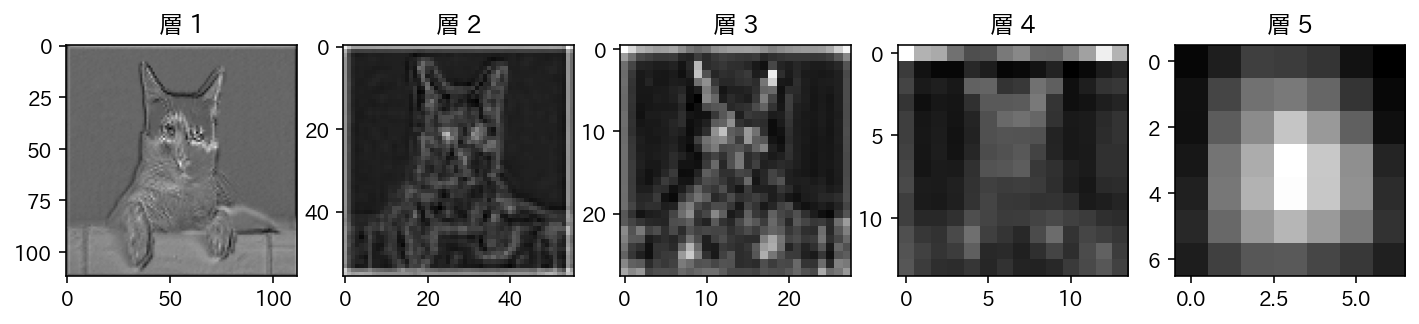

5

In [18]:
plt.figure(figsize=(12,4))
for i in range(len(saved_output.outputs)):
    plt.subplot(1,5,i+1)
    plt.gca().set_title(f'層 {i+1}')
    plt.imshow(saved_output.outputs[i].detach().numpy().mean(axis=1)[0], cmap='gray')

plt.show()    
    
len(saved_output.outputs)

ここから下は，当面無関係です。
無視してください。

In [31]:
X = torch.randn(1000, 3)
y = 3*X[:, 0] + 2*X[:, 1]**2 + X[:, 2]**3 + torch.randn(1000)
y = y.reshape(-1, 1)

In [32]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.features = torch.nn.Sequential(
            BlockLinear(3, 1, 20),
            torch.nn.ReLU(),
            BlockLinear(3, 20, 20),
            torch.nn.ReLU(),
            BlockLinear(3, 20, 20),
            torch.nn.ReLU(),
            BlockLinear(3, 20, 1),
        )

        self.lr = torch.nn.Linear(3, 1)

    def forward(self, x):
        x_pre = self.features(x)
        return self.lr(x_pre)

model = Model()

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()
for i in range(2000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y, y_pred)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())

In [ ]:
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 100).reshape(-1, 1)
x = torch.hstack(3*[x])

for i in range(3):
    plt.plot(
        x[:, 0].detach().numpy(),
        model.get_submodule('lr').weight[0][i].item() * model.get_submodule('features')(x)[:, i].detach().numpy())
    plt.title(f'Feature {i+1}')
    plt.show()


In [ ]:
!pip install git+https://github.com/rinnakk/japanese-clip.git

In [ ]:
from PIL import Image
import torch
import japanese_clip as ja_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
# ja_clip.available_models()
# ['rinna/japanese-clip-vit-b-16', 'rinna/japanese-cloob-vit-b-16']
# If you want v0.1.0 models, set `revision='v0.1.0'`
model, preprocess = ja_clip.load("rinna/japanese-clip-vit-b-16", cache_dir="/tmp/japanese_clip", device=device)
tokenizer = ja_clip.load_tokenizer()

#image = preprocess(Image.open("./data/dog.jpeg")).unsqueeze(0).to(device)
image = preprocess(Image.open("cat.jpg")).unsqueeze(0).to(device)
encodings = ja_clip.tokenize(
    texts=["犬", "猫", "象"],
    max_seq_len=77,
    device=device,
    tokenizer=tokenizer, # this is optional. if you don't pass, load tokenizer each time
)

with torch.no_grad():
    image_features = model.get_image_features(image)
    text_features = model.get_text_features(**encodings)
    
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1.0, 0.0, 0.0]]